In [1]:
%matplotlib widget
import sys
import numpy as np
import scipy as scs
import matplotlib.pyplot as plt

sys.path.append('../')
sys.path.append('../src')
sys.path.append('../data')

from pathlib import Path

datap = Path('../data')
%reload_ext autoreload
%aimport load
%aimport utils
%aimport spectr

In [2]:
#from definitions import *
from load import read_rad_prof, read_pol_prof, load_binary, extract_to_binary

from scipy.signal import welch, csd, correlate, coherence
from scipy.signal import correlation_lags # Note: requires a recent version of SciPy

from utils import dt, R, NR, Z, dZ, dX, Bt, normalized, fluctuations, theta_array_OPA, Bt_array_OPA
from spectr import get_tau_corr, Corr_profile, nperseg, plot_spec

In [3]:
%autoreload 1

p_binary = datap / '20100920#007192/dat.npy'
Datp = load_binary('poloidal')
Datr = load_binary('radial')

In [4]:
dat0 = Datp[0, 0]
dat1 = Datp[0, 1]
dat2 = Datr[2, 11]

In [5]:
f, Pxx = welch(dat0, nperseg=4 * 256)
corr = correlate(normalized(dat0), normalized(dat1), method='fft') / dat0.size
lags = correlation_lags(dat0.size, dat1.size)
tau = lags * dt
f, coh = coherence(dat0, dat1, fs = 1/dt, nperseg=1024)

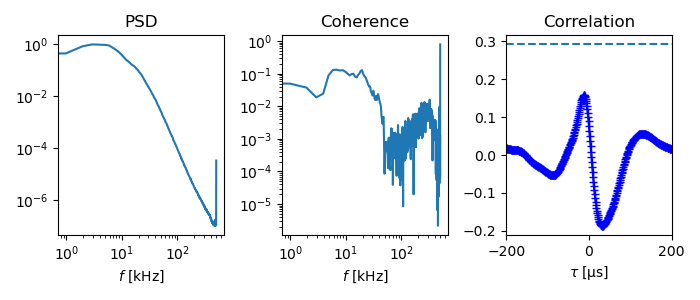

In [6]:
fig, axs = plt.subplots(1,3,figsize=(7,3))

[ax1,ax2,ax3] = axs
ax1.plot(f / 1e3, Pxx / Pxx.max())
ax2.plot(f / 1e3, coh)
ax3.plot(tau * 1e6, corr, 'b+-')

titles = ['PSD', 'Coherence', 'Correlation']
for ax in [ax1, ax2]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('$f$ [kHz]')
    
ax3.set_xlim(-200, 200)
ax3.set_xlabel(r'$\tau$ [µs]')
ax3.axhline(coh.max() / np.exp(1), ls='--')

for i, ax in enumerate(axs):
    ax.set_title(titles[i])
plt.tight_layout()

In [29]:
# compute a value proportional to the radial particle turbulent transport at a given time step and a given position
# Warning : three probes are needed for each measure, so the position is not accurate

def radial_turbulent_transport(position):
    #position must be an integer between 0 and 12
    ntilde = Datr[position, 0] - np.mean(Datp[position+1, 0])
    
    if position != 12:
        vtilde = (Datp[(2*position + 2)%64, Nt]- Datp[2*position, Nt]  - np.mean(Datp[(2*position + 2)%64, Nt] - Datp[2*position, Nt]) )/(2*dX*Bt_array_OPA[2*position])
    
    if Nt == 0:
        vtilde = (Datp[(2*position + 2)%64, Nt]- Datp[2*position, Nt]  - np.mean(Datp[(2*position + 2)%64, Nt] - Datp[2*position, Nt]) )/(2*dX*Bt_array_OPA[2*position])
    
    Gamma = np.mean(ntilde*vtilde)
    
    return Gamma

In [30]:
Datr.shape

(3, 13, 1048576)

In [37]:
# compute a value proportional to the poloidal particle turbulent transport at a given time step and a given position
# Warning : three probes are needed for each measure, so the position is not accurate
def poloidal_turbulent_transport(position, Nt, shot = 'poloidal'):
    if shot == 'poloidal':
        #position must be an integer between 0 and 31
        ntilde = Datp[2*position+1, Nt] - np.mean(Datp[2*position+1, Nt])

        if Nt == 0:
            vtilde = (Datp[(2*position + 2)%64, Nt]- Datp[2*position, Nt]  - np.mean(Datp[(2*position + 2)%64, Nt] - Datp[2*position, Nt]) )/(2*dX*Bt_array_OPA[2*position])

        Gamma = np.mean(ntilde*vtilde)
    elif shot == 'radial':
        #position must be an integer between 0 and 12
        ntilde = Datr[1, position,:] - np.mean(Datr[1, position,:])
        vtilde = (Datr[2, position,:]- Datr[0, position,:]  - np.mean(Datr[2, position,:] - Datr[0, position,:]) )/(2*dZ*Bt)
        Gamma = np.mean(ntilde*vtilde)
    return Gamma    

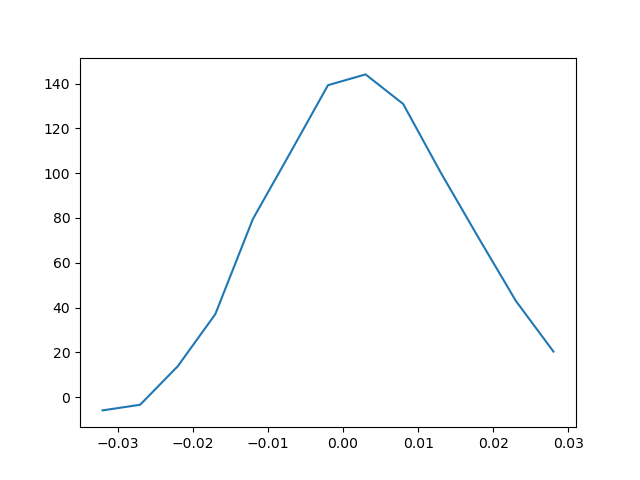

In [38]:
Gamma_rad = np.zeros(13)

for position in range(13):
    Gamma_rad[position] = poloidal_turbulent_transport(position, 0, 'radial')

plt.figure()
plt.plot(R, Gamma_rad)
plt.show()

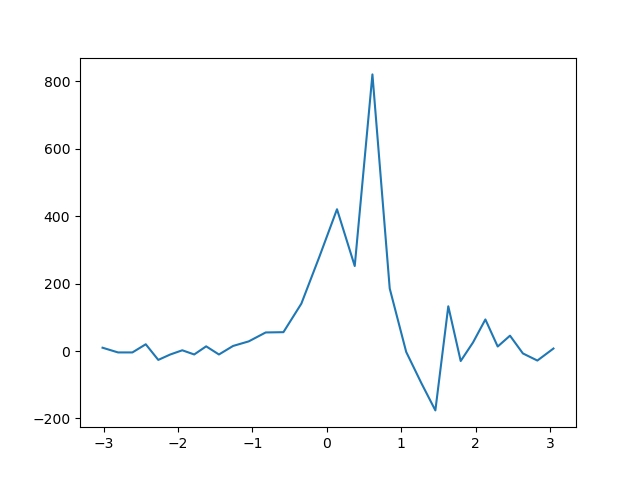

In [39]:
# the position of the measure will be the position of the probe that measures I_sat
# Nt = 0 for OPA
Gamma_OPA = np.zeros(32)

for position in range(32):
    Gamma_OPA[position] = poloidal_turbulent_transport(position, 0)

plt.figure()
plt.plot(theta_array_OPA[1: :2], Gamma_OPA)
plt.show()

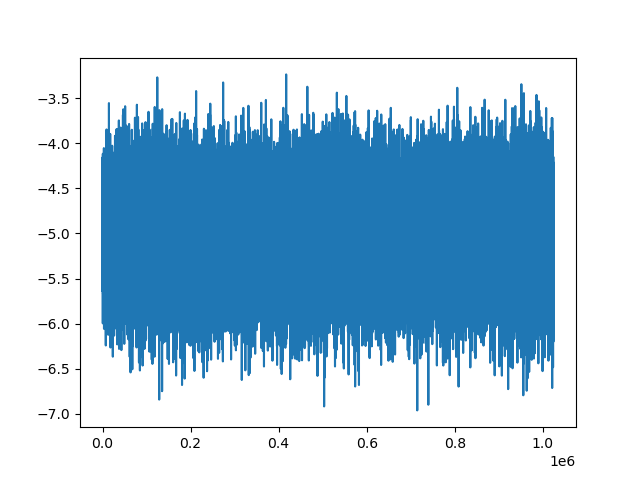

In [40]:
# Compute the temporal mean of the poloidal zonal potential
time = len(Datp[0, 0])
zonal_potential_OPA = np.zeros(time)
for t in range(time):
    zonal_potential_OPA[t] = np.mean(Datp[:, 1, t])

plt.figure()
plt.plot(zonal_potential_OPA)
plt.show()   

In [41]:
A = scs.signal.welch(zonal_potential_OPA)

In [42]:
f, Pxx = welch(dat0, fs=1e6, nperseg=4 * 256)

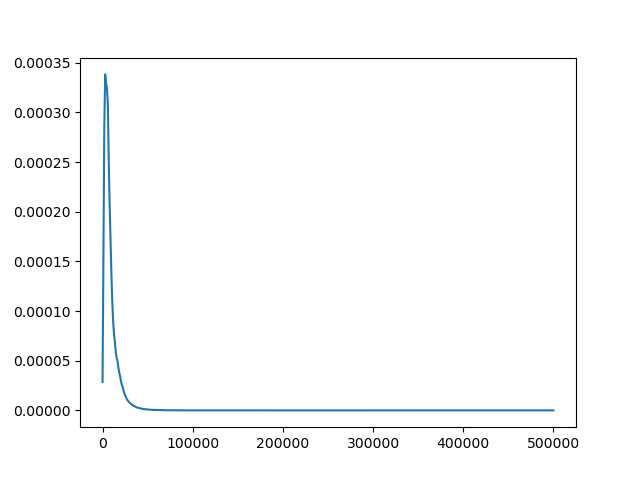

In [43]:
plt.figure()
plt.plot(f, Pxx)
plt.show() 

In [10]:
A = np.fft.fft(zonal_potential_OPA)

In [ ]:
plt.figure()
plt.plot(np.real(A))
plt.show() 

In [71]:
l = np.array([1, 2, 3, 4])
l[1:]
int(25.)

25

In [50]:
window = 500
averaging_nb = 10

In [51]:
def blobholes(normalized_array, alpha = 2.3):
    indice = np.where(abs(normalized_array) >= alpha)[0]
    indiceblob = []
    indicehole = []
    for i in indice:
        if normalized_array[i]>0:
            indiceblob.append(i)
        else:
            indicehole.append(i)  
    return indiceblob, indicehole   

In [94]:
def blobhole_windowing(indices, window = window):
    l = [[indices[0]]]
    for i in indices[1:]:
        if i - l[-1][0] < 2*window :
            l[-1].append(i)
        else:
            l.append([i])
    n = len(l)
    windowed_indices = np.zeros(n, dtype = int)
    for j in range(n):
        windowed_indices[j] = int((l[j][-1]+ l[j][0])//2)
    return windowed_indices

In [126]:
def blobholes_meanprof(normalized_array, windices, window = window):
    #averaging blob/hole
    mean_profile = np.zeros(2*window)
    
    for i in windices:
        mean_profile += normalized_array[ i- window : i + window]
    
    mean_profile /= len(windices)
    return mean_profile

In [127]:
def blobholes_local_meanprof(normalized_array, windices, averaging_nb = averaging_nb):
    #averaging blob/hole but only over a few pics
    nb_profiles = len(windices)//averaging_nb
    
    mean_profiles = np.zeros((nb_profiles, 2*window))
  
    compteur = 0
    m = 0
    while compteur < len(windices) and m < nb_profiles:
        somme = 0
        while somme <= averaging_nb:
            somme += 1
            i = windices[compteur]
            mean_profiles[m] += normalized_array[ i- window : i + window]/averaging_nb
        compteur += 1
        m +=1
    return mean_profiles

In [128]:
datr_norm = normalized(Datr[0, 0])
Isat_norm = normalized(Datr[1, 0])

indiceblob, indicehole = blobholes(datr_norm)

windiceblob = blobhole_windowing(indiceblob)

phi_meanprof = blobholes_meanprof(datr_norm, windiceblob)
Isat_meanprof = blobholes_meanprof(Isat_norm, windiceblob)
phi_mean_profiles = blobholes_local_meanprof(datr_norm, windiceblob)
phi_mean_profiles.shape

(13, 1000)

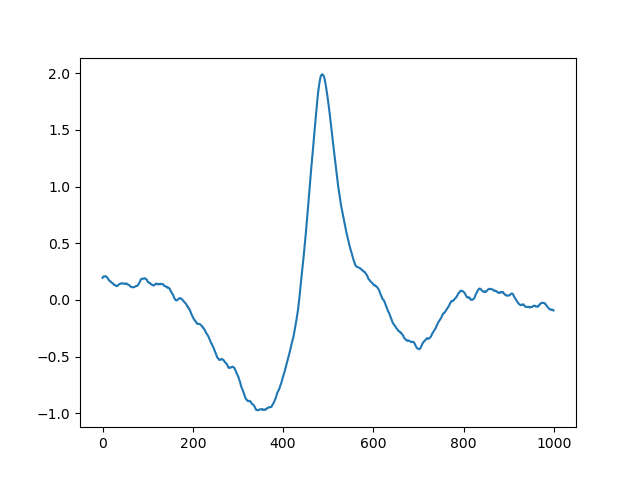

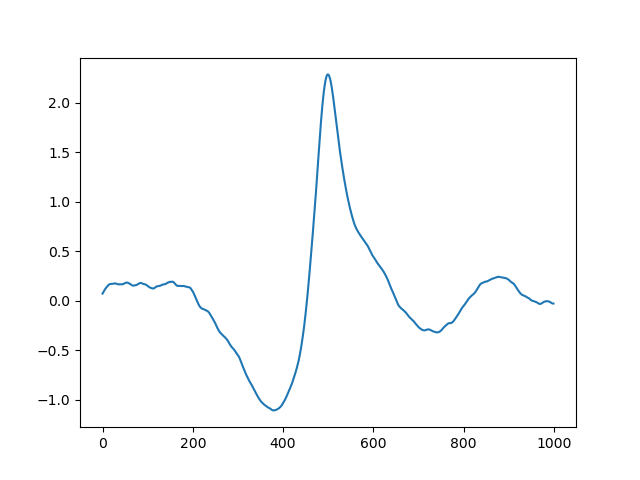

In [129]:
plt.figure()
plt.plot(Isat_meanprof)
plt.show()
plt.figure()
plt.plot(phi_meanprof)
plt.show()

In [7]:
def conditional_averaging(alpha = 3, tau = 1000, position = 1, ip = 1, shot = 'radial' ):
    """

    Parameters
    ----------
    alpha : number
        value for detecting spikes. The default is 2.
    tau : number
        size of the averaging. The default is 1000.
    iR : number
        index for the radial position of the triple probe. Must be an integer between  0 and 12
    ip : number
        index of the probe in the triple probe setup. Must be either, 0,1 or 2.

    Returns
    -------
    Dat_Norm : 1D array.
    Returns the normalized blobs and holes, equals 0 elsewhere
    indice_blob : 1D array,
    returns the indices of the blobs
    indice_hole : 1D array,
    returns the indices of the holes
    Dat_hole : 1D array
        returns the conditionnal averaging of the blobs
    Dat_blob : 1D array
        returns the conditionnal averaging of the holes

    """
    if shot == 'radial':
        dat_norm = normalized(Datr[ip, position,:])
    
    if shot == 'poloidal':
        dat_norm = normalized(Datp[position, ip,:])
    
    indice = np.where(abs(dat_norm) >= alpha)[0]
    indiceblob = []
    indicehole = []
    for i in indice:
        if dat_norm[i]>0:
            indiceblob.append(i)
        else:
            indicehole.append(i)
    Dat_Norm = np.zeros_like(dat_norm)
    Dat_Norm = dat_norm[indice]
    #initialisation averaging
    step = int(tau/dt)


    #averaging blob
    Dat_blob = np.zeros(2*step)
    ipic = indiceblob[0]
    if ipic-step>0:
        Dat_blob = dat_norm[ipic-step:ipic+step]
    for i in indiceblob:
        if i-step>0 and i+step<len(dat_norm)-1:
            if i>ipic+step: #verification overlapping$
                #le i pris en compte correspond au centre du signal
                Dat_blob = Dat_blob + dat_norm[i-step:i+step]
                ipic = i
    Dat_blob /= len(indiceblob)

    #averaging hole
    Dat_hole  = np.zeros(2*step)
    ipic = indicehole[0]
    if ipic-step>0:
        Dat_hole  = dat_norm[ipic-step:ipic+step]
    for i in indicehole:
        if i-step>0 and i+step<len(dat_norm)-1:
            if i>ipic+step: #verification overlapping
                Dat_hole  = Dat_hole  + dat_norm[i-step:i+step]
                ipic = i
    Dat_hole  /= len(indicehole)
    

    return Dat_Norm, indiceblob, indicehole,  Dat_blob, Dat_hole



In [ ]:
Dat_Norm, indiceblob, indicehole,  Dat_blob, Dat_hole = blob_study()

In [ ]:
theta_array_OPA = np.array([-3.1235280, -3.0137569, -2.9073485, -2.8051417, -2.7071847, -2.6126248, -2.5215145, -2.4330854, -2.3478083, -2.2648591, -2.1842471, -2.1040693, -2.0234246, -1.9421344, -1.8614906, -1.7821543, -1.7024737, -1.6212623, -1.5376113, -1.4496697, -1.3572263, -1.2596373, -1.1571439, -1.0493933, -0.93729199, -0.82152736, -0.70318702, -0.58321263, -0.46279019, -0.34215081, -0.22190346, -0.10223254, 0.017224783, 0.13673208, 0.25606317, 0.37513834, 0.49413465, 0.61282050, 0.73003303, 0.84526151, 0.95768375, 1.0665708, 1.1713279, 1.2715163, 1.3671756, 1.4586130, 1.5469808, 1.6322630, 1.7158621, 1.7989729, 1.8817460, 1.9647129, 2.0477027, 2.1307102, 2.2136460, 2.2962418, 2.3788249, 2.4615021, 2.5462539, 2.6346722, 2.7287933, 2.8293017, 2.9353781, 3.0454504])
Bt_array_OPA    = np.array([81.413653,  81.554947, 81.688886, 81.785425, 81.805867, 81.677173, 81.418237, 80.978830, 80.410903, 79.665974, 78.762967, 77.573484, 76.043523, 74.128822, 72.002351, 69.823963, 67.703469, 65.680512, 63.775266, 61.973155, 60.285373, 58.697925, 57.225119, 55.836454, 54.551215, 53.374512, 52.301156, 51.361428, 50.541115, 49.880512, 49.379216, 49.074743, 48.995043, 49.098658, 49.399573, 49.909240, 49.413465, 51.404843, 52.347126, 53.423241, 54.605184, 55.900020, 57.305778, 58.811793, 60.431098, 62.159817, 64.012493, 65.972022, 68.033278, 70.161485, 72.300145, 74.362368, 76.264515, 77.940651, 79.336531, 80.374150, 81.064533,  81.410054, 81.525579, 81.490495, 81.405933, 81.336058, 81.291581, 81.331378])*10**(-3)



In [ ]:
plt.figure()
plt.plot(theta_array_OPA, Bt_array_OPA)
plt.show()

In [ ]:
np.shape(theta_array_OPA) 


In [ ]:
np.shape(Bt_array_OPA)